>- se nao posso usar lista de funcoes
>- vou ter que recorrer as flags integer com if/case
>- usar npar e rpar
>- uma funcao alfa
>- if 1 ou if 2 chama funcao pr ou at
>- vetor kpr com elementos vazios para as especies at
>- ou vetor de indices para localizar cada especie aplicavel no vetor pr reduzido
>- idem com k1k2k3 para as especies aplicaveis do at
>- ou as especies pr tem um rpar=kpr e as especies at tem um rpar=k1,k2,k3 <! acho q pode ser assim - aliasing

In [4]:
import numpy as np
from numba import njit

from matplotlib import pyplot as plt

# PR

In [246]:
R=8.314

#%%
ncomp=2

#ethanol
Tc1=513.9
Pc1=61.4e5
w1=0.644

#water
Tc2=647.3
Pc2=221.2e5
w2=0.344

k21=1
k22=1
k23=1
#%%

@njit
def f_Aalpha_AT(T,rpar):
    ac,Tc,k1,k2,k3=rpar
    #ToDo
    Aalpha = ac
    return Aalpha

@njit
def f_Aalpha_PR(T,rpar): #factory #ou faço factory ou faço duas funções q vao ter q receber algum tipo de npar rpar
    ac,Tc,kPR = rpar
    alpha = (1. +kPR*(1.-np.sqrt(T/Tc)))**2
    Aalpha = ac*alpha
    return Aalpha
    
    
@njit
def f_dAalphadT_PR(T,rpar):
    ac,Tc,kPR = rpar
    dalphadT = ( #multiline
        2.*(1. + kPR*(1.-np.sqrt(T/Tc)))*
        kPR*(-1.)*(
        1./(2.*(np.sqrt(T/Tc)))
        )*(1./Tc)
    )
    dAalphadT = ac*dalphadT
    return dAalphadT


t_alpha_PR = (fiPR,f_Aalpha_PR,f_dAalphadT_PR)
#para estimar k1k2k3 etc preciso jitar a inicialização - não pode factory
#ou duas funções q vao ter q receber algum tipo de npar rpar para terem interfaces compatíveis 
#apesar do esquema de parametrização diferente
#ou uma jitclass para salvar os parametros que aqui estão sendo congelados...
#teria um jitobj para cada comp

#pre jit variables
#per component requires Pc/Tc for ac and bc, plus w for alfaPR or a1a2a3 for alfaAT
comp1={'name':'ethanol','a':[t_alpha_PR,Tc1,Pc1,w1],'b':[Tc1,Pc1]}
#comp2={'name':'water','a':[fAT,Tc2,Pc2,k21,k22,k23],'b':[Tc2,Pc2]}
comp2={'name':'water','a':[t_alpha_PR,Tc2,Pc2,w2],'b':[Tc2,Pc2]}

#interactions
k12=.0

ncomp = ncomp
#vEoS specific parameters 
sigma = 1.0 + np.sqrt(2.)
epsilon = 1.0 - np.sqrt(2.)



In [247]:
@njit
def fb(*props):
    Tc,Pc = props
    b=0.07780*R*(Tc)/(Pc)
    return b

@njit
def fiPR(*props):
    Tc,Pc,w = props
    ac=0.45724*(R**2)*((Tc)**2)/(Pc)
    kPR = 0.37464 + 1.54226*w-0.26992*(w)**2
    npar=3
    rpar=np.array([ac, Tc,kPR])
    return rpar 

@njit
def fiAT(*props):
    Tc,Pc,k1,k2,k3 = props
    ac=0.45724*(R**2)*((Tc)**2)/(Pc)
    npar=5
    rpar=np.array([ac, Tc,k1,k2,k3])
    return rpar

# bc =  tuple(fb(*comp['b']) for comp in (comp1,comp2)) 
# print( bc )

# alfafunci=tuple( tuple(funcalfa(comp['a']) for funcalfa in (comp['a'][0],))[0] for comp in (comp1,comp2) )
# print( alfafunci )



k = np.zeros((ncomp,ncomp))
k[0,1]=k12
k[1,0]=k12

# alfafunci[0](100)

In [277]:
#@njit #jitable init function to recalc bc, ac, kpr
def init(*comps):
    
    '''transforms Tc, Pc, w into bc, ac and kPR constants,
    fills in rpar variables
    allocates tuples of alfa and dalfa funcs
    '''
    
    bc =  tuple(fb(*comp['b']) for comp in (comp1,comp2)) 
    # print( bc )
    
    alfafunci=[0]
    dalfafunci=[0]
    rpari=[0]    
    
    alfafuncs = tuple (comps[i]['a'][0][1] for i in range(ncomp)) 
    dalfafuncs = tuple ( comps[i]['a'][0][2] for i in range(ncomp)) 
    rpars = tuple ( (comps[i]['a'][0][0])(*(comps[i]['a'][1:])) for i in range(ncomp)) 
    
    return bc, rpars, alfafuncs, dalfafuncs

bc, rpars, alfafuncs, dalfafuncs = init(comp1,comp2) #rpars for alpha
bc, rpars, alfafuncs, dalfafuncs


((5.41377077980456e-05, 1.8928234229656418e-05),
 (array([  1.35941833, 513.9       ,   1.2559099 ]),
  array([5.98673932e-01, 6.47300000e+02, 8.73236187e-01])),
 (CPUDispatcher(<function f_Aalpha_PR at 0x7f523913db90>),
  CPUDispatcher(<function f_Aalpha_PR at 0x7f523913db90>)),
 (CPUDispatcher(<function f_dAalphadT_PR at 0x7f52386a0d40>),
  CPUDispatcher(<function f_dAalphadT_PR at 0x7f52386a0d40>)))

In [278]:
@njit
def _f_bmix(x,bc):
    bm = 0.
    for i in range(ncomp):
        bm += x[i]*bc[i]
    return bm


# _f_bmix(np.array([.5,.5]))

In [279]:
@njit
def alfafunc(i,T,rpar): #uses frozen jitted alfafuncis
    #this manifold function returning f jits fine;
    #passing the list of functions directly failed to jit in the version tested
    #i dont remember the context when it failed
    if i==0:
        f= alfafuncs[0](T,rpar)
    elif i==1:
        f= alfafuncs[1](T,rpar)
    return f
    
alfafunc(0,100,np.array([1,2,3]))

296.29437251522864

In [280]:
@njit
def dalfafunc(i,T,rpar): #uses frozen jitted alfafuncis
    if i==0:
        f= dalfafuncs[0](T,rpar)
    elif i==1:
        f= dalfafuncs[1](T,rpar)
    return f
    
dalfafunc(0,100,np.array([1,2,3]))

3.6514718625761433

In [326]:
@njit
def Pressure(T,V,x,bc,rpars,k):
    bm=_f_bmix(x,bc)
    Aalpham,Aalpha=_f_Aalphamix(T,x,rpars,k)
    P = (R*T)/(V-bm) - Aalpham/(V**2 + 2*bm*V - bm**2) #sigma & epsilon hardcoded here
    return P

@njit
def _f_Aalpha(T,rpars):
    Aalpha=np.zeros(ncomp)
    for i in range(ncomp):
        Aalpha[i] = alfafunc(i,T,rpars[i])
    return Aalpha

@njit
def _f_Aalphamix(T,x,rpars,k):
    Aalpha=_f_Aalpha(T,rpars)
    Aalpham = 0.
    for i in range(ncomp):
        for j in range(ncomp):
            Aalpham += x[i]*x[j]*np.sqrt(Aalpha[i]*Aalpha[j])*(1.-k[i,j])
    return Aalpham, Aalpha

@njit
def _f_dbdn(x,bc):
    bm=_f_bmix(x,bc)
    dbdn=np.zeros(ncomp)
    for i in range(ncomp):
        dbdn[i]=bc[i]
    return dbdn, bm

@njit
def _f_dAalphadn(T,x,rpars,k):
    Aalpham, Aalpha = _f_Aalphamix(T,x,rpars,k)
    dAalphadn = np.zeros(ncomp)
    sum1 = 0.
    for i in range(ncomp):
        sum1 = 0.
        for j in range(ncomp):
            sum1 += x[j]*np.sqrt(Aalpha[j])*(1.-k[i,j])
        dAalphadn[i]=np.sqrt(Aalpha[i])*sum1
    return dAalphadn, Aalpham



Pressure(T=298,V=3e-1,x=np.array([.5,.5]),bc=bc,rpars=rpars,k=k)

8242.136886044345

In [327]:
@njit
def Volume(T,P,x,bc,rpars,k):
    
    '''
    returns either (Vl,Vv) if 3 physical roots or (Vl,Vl) or (Vv,Vv) if one physical root
    not designed for negative pressure (will run and return (Vl,Vi))
    # T em unidade K
    # P em unidade Pa
    # x array normalizado
    '''    


    bm=_f_bmix(x,bc)
    Aalpham,_=_f_Aalphamix(T,x,rpars,k)

#     c3 = 1.                                                                # Coeficiente para V^3 para EoS PR
#     c2 = bm - R*T/P                                                # Coeficiente para V^2 para EoS PR
#     c1 = Aalpham/P - 3.*(bm**2) - 2.*bm*R*T/P     # Coeficiente para V^1 para EoS PR
#     c0 = (R*T*bm**2)/P + bm**3 - Aalpham*bm/P    # Termo independente para EoS PR

    c0 = -(bm**3)*sigma*epsilon + (-R*T*sigma*epsilon*(bm**2)-bm*Aalpham)/P
    c1 = (bm**2)*(sigma*epsilon-epsilon-sigma) + ((R*T)*(-sigma*bm-epsilon*bm) + Aalpham)/P
    c2 = epsilon*bm+sigma*bm-bm-R*T/P
    c3 = 1.
#        print("cs",c3,c2,c1,c0)
    
    #Vs=0
    Vs=np.roots( np.array( (c3+0j,c2+0j,c1+0j,c0+0j) ) ) #actual np.array cast from tuple of complex typed coefficients
    
    #remove imag
    imagtol=1e-9
    
    condition=(np.abs(Vs.imag) < imagtol) & (Vs.real > bm)
    nphys=np.sum(condition)
    #Vsr = np.where( condition,
    #                 Vs.real,
    #                 -1.)
    
    Vsr = np.array( (np.nanmin(Vs[condition].real),
                     np.nanmax(Vs[condition].real)  ) )
    return Vsr

print( Volume(T=298,P=10*8242.970840575628,x=np.array([.5,.5]),bc=bc,rpars=rpars,k=k)) 
print( Volume(T=298,P=1000*8242.970840575628,x=np.array([.5,.5]),bc=bc,rpars=rpars,k=k)) 

[4.20685647e-05 2.94488752e-02]
[4.19383141e-05 4.19383141e-05]


In [328]:
#phase equilibrium common
@njit
def fugacity_coeff(T,V,x,bc,rpars,k): #for a vdw1f mixrule cubic eos with sigma!=epsilon
    P=Pressure(T,V,x,bc,rpars,k)
    dbdn,bm = _f_dbdn(x,bc)
    dAalphadn, Aalpham = _f_dAalphadn(T,x,rpars,k)
    qsi = (1./(bm*(epsilon-sigma)))*np.log((V+epsilon*bm)/(V+sigma*bm))
    lnPhi = np.zeros(ncomp)
    for i in range(ncomp):
        lnPhi[i] = ( #multiline
            (dbdn[i]/bm)*((P*V)/(R*T)-1.) #&
            -np.log(P*(V-bm)/(R*T)) #& #goes nan if P negative
            -(Aalpham/(R*T))*qsi*((2.*dAalphadn[i]/Aalpham) #&
            -(dbdn[i]/bm))
                             )#done
    phi = np.exp(lnPhi)
    return phi

fugacity_coeff(298,1e-2,np.array((.5,.5)),bc,rpars,k)

array([0.92108948, 0.96742443])

In [329]:
@njit
def _f_dAalphadT(T,x,rpars):
    dAalphadT=np.zeros(ncomp)
    for i in range(ncomp):
        dAalphadT[i] = dalfafunc(i,T,rpars[i])
    return dAalphadT

@njit
def _f_dAalphamdT(T,x,rpars,k):
    _, Aalpha=_f_Aalphamix(T,x,rpars,k)
    dAalphadT=_f_dAalphadT(T,x,rpars)

    dAalphamdT = 0.
    for i in range(ncomp):
        for j in range(ncomp):
            dAalphamdT += ( #multiline
                x[i]*x[j]*
                (1./(2.*np.sqrt(Aalpha[i]*Aalpha[j])))*
                (Aalpha[i]*dAalphadT[j]+dAalphadT[i]*Aalpha[j])*
                (1.-k[i,j])
            )
    #print(dAalphamdT)
    #numerical
    #AalphammaisT,_=_f_Aalphamix(T+1e-3,x)
    #AalphammenosT,_=_f_Aalphamix(T-1e-3,x)
    #dAalphamdT=(AalphammaisT-AalphammenosT)/(2.*1e-3)
    #print(dAalphamdT)
    return dAalphamdT

#other spec flashes
@njit
def f_H_res(T,V,x,bc,rpars,k):
    P=Pressure(T,V,x,bc,rpars,k)
    bm=_f_bmix(x,bc)
    dAalphamdT = _f_dAalphamdT(T,x,rpars,k)
    Aalpham, _ = _f_Aalphamix(T,x,rpars,k)
    qsi = (1./(bm*(epsilon-sigma)))*np.log((V+epsilon*bm)/(V+sigma*bm)) #again
    H_res = P*V - R*T + (T*dAalphamdT-Aalpham)*qsi
#        print(Aalpham)
    return H_res

@njit
def f_S_res(T,V,x,bc,rpars,k):
    P=Pressure(T,V,x,bc,rpars,k)
    bm=_f_bmix(x,bc)
    dAalphamdT = _f_dAalphamdT(T,x,rpars,k)
    Aalpham, Aalpha = _f_Aalphamix(T,x,rpars,k)
    qsi = (1./(bm*(epsilon-sigma)))*np.log((V+epsilon*bm)/(V+sigma*bm)) #again
    S_res = R*np.log((P*(V-bm))/(R*T)) + dAalphamdT*qsi
    return S_res



In [330]:
def test():
    print("@ input/system")
    print("ncomp :",ncomp)
    print("cnames :",comp1['name'],comp2['name'])
    print("Tc :",Tc1,Tc2)
    print("Pc :",Pc1,Pc2)
    print("acentric :",w1,w2)
    print("k :",k)
    T=283.    #K
    P=40e4 #Pa
    x=np.array([0.2, 0.8])
    print("@ input/condition")
    print("T :",T)
    print("P :",P)
    print("x :",x)
    #output
    print("@ output")
    VL,VV=Volume(T,P,x,bc,rpars,k)
    print("VL :",VL)
    print("VV :",VV)
    PL=Pressure(T,VL,x,bc,rpars,k)
    PV=Pressure(T,VV,x,bc,rpars,k)
    print("PL = PV :",PL,"=",PV)
    fL=fugacity_coeff(T,VL,x,bc,rpars,k)
    print("fL :",fL)
    fV=fugacity_coeff(T,VV,x,bc,rpars,k)
    print("fV :",fV)
    HrL=f_H_res(T,VL,x,bc,rpars,k)
    print("HrL :",HrL)
    HrV=f_H_res(T,VV,x,bc,rpars,k)
    print("HrV :",HrV)
    SrL=f_S_res(T,VL,x,bc,rpars,k)
    print("SrL :",SrL)
    SrV=f_S_res(T,VV,x,bc,rpars,k)
    print("SrV :",SrV)

    #optimization issues
    #i will recalc bmix and amix when calling phi and when calling v
    #optimizing this would require that either bmix were public and required prior to calc V
    # or that there were both a public calcv(t,p,x) and a private calv(t,p,x,am,bm) and either class variable bm and am wih status checking at every call or combo calls calcv(tpx) calcphi(tpx) calcv_and_phi(tpx) combinatorially.
    

In [332]:
test()

@ input/system
ncomp : 2
cnames : ethanol water
Tc : 513.9 647.3
Pc : 6140000.0 22120000.0
acentric : 0.644 0.344
k : [[0. 0.]
 [0. 0.]]
@ input/condition
T : 283.0
P : 400000.0
x : [0.2 0.8]
@ output
VL : 2.9200017519158347e-05
VV : 0.00533861642425051
PL = PV : 399999.9999984503 = 400000.0000000005
fL : [0.07955803 0.00384853]
fV : [0.85325403 0.93170036]
HrL : -43278.87051506722
HrV : -566.4497670015289
SrL : -111.73878502838764
SrV : -1.2671736718464732


# NRTL

In [333]:
@njit
def Gamma(T,c_x,q_alpha, q_A):
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

In [334]:
#test
Gamma(T=298, c_x=np.array([.5,.5]), q_alpha=np.zeros([2,2]), q_A=np.zeros([2,2]))

array([1., 1.])

In [335]:
#etanol
@njit
def PantoineA(T): #http://webbook.nist.gov/cgi/cbook.cgi?ID=C64175&Mask=4&Type=ANTOINE&Plot=on
    Aa = 5.24677
    Ba = 1598.673
    Ca = -46.424
    return (10**(Aa - Ba/(T + Ca)))*1e5
PsatA = PantoineA(298)
print (PsatA)

7800.772324241532


In [336]:
#agua
@njit
def PantoineB(T): #http://webbook.nist.gov/cgi/cbook.cgi?ID=C64175&Mask=4&Type=ANTOINE&Plot=on
    A=6.20963
    B=2354.731
    C=7.559
    return (10**(A - B/(T + C)))*1e5
PsatB = PantoineB(373)
print (PsatB)

105213.55563804183


In [337]:
fPSATs=(PantoineA,PantoineB)

@njit
def mfPSATs(i,T):
    if i==0:
        ans=fPSATs[0](T)
    elif i==1:
        ans=fPSATs[1](T)
    #elif i==2:
    #    ans=fPSATs[2](T)
    #elif i==3:
    #    ans=fPSATs[3](T) #wont compile past jit actual tuple size
    #...
    return ans

print( fPSATs[0](300) )
print( mfPSATs(0,300) )

8755.032111542881
8755.032111542881


In [352]:
alpha=np.zeros([2,2])
alpha[1,0]=alpha[0,1]=0.4
A=np.zeros([2,2])

@njit
def Pbol(x,T,y,alpha,A): #pbolgamma
    Psati = np.zeros((2,))
    
    gammas = Gamma(T,x,alpha,A)
    
    for i in range(2):
        Psati[i] = mfPSATs(i,T) #mesmo esquema do alfa aqui, e depois no poynting...

    Pbol_=0
    for i in range(0,2):
#        print(i,Pbol_)
        Pbol_ += x[i]*gammas[i]*Psati[i]
    
    #calculo das composicoes do vapor
    for i in range(0,2):
        y[i] = x[i]*gammas[i]*Psati[i]/Pbol_
        
        
#    print(y_out, Gamma, x, Psati, Pbol_)
    return Pbol_

In [353]:
#test
y=np.zeros([2])
x=np.array([.5,.5])
T=298
Pbol(x,T,y,alpha,A) #expose adjustable parameters only, interaction matrix, (pure parameters are adjusted a priori)

5493.674993293001

In [370]:
alpha=np.zeros([2,2])
alpha[1,0]=alpha[0,1]=0.4
A=np.zeros([2,2])

@njit
def Pbol_gammaphi(x,T,y,alpha,A,k):
    
    gammas = Gamma(T,x,alpha,A)
    Psati = np.zeros((2,))
    for i in range(2):
        Psati[i] = mfPSATs(i,T) #mesmo esquema do alfa aqui, e depois no poynting...    
    
    #guess
    Pbol_=Pbol(x,T,y,alpha,A) #could give gamma and psats rdy    
    
    tol=1e-12
    res=1.
    
    j=0
    jmax=100
    while res > tol and j<jmax:
        #eos
        vols=Volume(T,Pbol_,y,bc,rpars,k)
        #print(vols)
        Vv=vols[1]
        phiV=fugacity_coeff(T,Vv,y,bc,rpars,k)
        #print(phiV)
        
        Pbol_o=Pbol_*1. #scalar copy
        #algorithm
        Pbol_=0
        for i in range(0,2):
    #        print(i,Pbol_)
            Pbol_ += x[i]*gammas[i]*Psati[i]/phiV[i]

        #calculo das composicoes do vapor
        for i in range(0,2):
            y[i] = x[i]*gammas[i]*Psati[i]/(Pbol_*phiV[i])
        
        res=np.abs(Pbol_-Pbol_o)
        j+=1
        
#    print(y_out, Gamma, x, Psati, Pbol_)




    return Pbol_ #,j

In [371]:
#test
y=np.zeros([2])
x=np.array([.5,.5])
T=298
print( Pbol(x,T,y,alpha,A) ) 
print( Pbol_gammaphi(x,T,y,alpha,A,k) ) #expose adjustable parameters only, interaction matrix, (pure parameters are adjusted a priori)

5493.674993293001
5502.30289841195


In [ ]:
#Pbolha -> robusto para envelopes convencionais
#Porvalho -> para fazer cálculos de orvalho de água em gas natural (x~1 sempre)
#Pbolha/Porvalho phiphi (Pbeta)

In [389]:
alpha=np.zeros([2,2])
alpha[1,0]=alpha[0,1]=0.4
A=np.zeros([2,2])

@njit
def Porv_gammaphi(y,T,x,alpha,A,k):
    
    
    Psati = np.zeros((2,))
    for i in range(2):
        Psati[i] = mfPSATs(i,T) #mesmo esquema do alfa aqui, e depois no poynting...    
    
    #guess
    Porv_= np.sum( y[:]/(Psati[:]) )
    
    gammas=np.ones((ncomp,))
    
    tol=1e-12
    res=1.
    
    j=0
    jmax=100
    while res > tol and j<jmax:
        #eos
        vols=Volume(T,Porv_,y,bc,rpars,k)
        #print(vols)
        Vv=vols[1]
        phiV=fugacity_coeff(T,Vv,y,bc,rpars,k)
        #print(phiV)
        
        Porv_o=Porv_*1. #scalar copy
        #algorithm
        iPorv_=0
        for i in range(0,2):
    #        print(i,Pbol_)
            iPorv_ += y[i]*phiV[i]/(gammas[i]*Psati[i])
        
        Porv_=1./iPorv_

        #calculo das composicoes do vapor
        for i in range(0,2):
            x[i] = y[i]*Porv_*phiV[i]/(gammas[i]*Psati[i])
        
        gammas = Gamma(T,x,alpha,A)
        
        res=np.abs(Porv_-Porv_o)
        j+=1
        
#    print(y_out, Gamma, x, Psati, Pbol_)




    return Porv_ #,j

In [390]:
#test
y=np.zeros([2])
x=np.array([.5,.5])
T=298
P=Pbol_gammaphi(x,T,y,alpha,A,k)
print( P,x,y ) 

P=Porv_gammaphi(y,T,x,alpha,A,k) 
print( P,x,y ) 

5502.30289841195 [0.5 0.5] [0.71022558 0.28977442]
5502.30289841195 [0.5 0.5] [0.71022558 0.28977442]


In [ ]:
#flash phiphi

class c_FlashLV():
    ''' no docs'''
    
    def __init__(self):
        return

    #Eq. 1 - The Rachford-Rice residue function
    def RES_RR(self,Ncomp,z,K,BETA):
        import numpy as np
        RES = 0.
        for i in range(Ncomp):
            RES += z[i]*( (K[i]-1.) / (1.+BETA*(K[i]-1.)) )            
        return RES

    def Newton(self,Ncomp,z,K,BETA):
        import numpy as np
        RES=1
        TOL=1e-9
        MAXi=100
        i=0
        while (np.abs(RES)>TOL and i < MAXi):
            RES=self.RES_RR(Ncomp,z,K,BETA)
            step=1e-5
            JAC=(self.RES_RR(Ncomp,z,K,BETA+step)-self.RES_RR(Ncomp,z,K,BETA-step))/(2*step)
            BETA-=RES/JAC
            i+=1
    #        print(i)
        return BETA
        
    def update_x(self,Ncomp,z,K,BETA):
        import numpy as np
        x=np.zeros(Ncomp)
        y=np.zeros(Ncomp)
        for i in range(Ncomp):
            x[i] = z[i]*( (1.) / (1+BETA*(K[i]-1.)) )            
            y[i] = K[i]*x[i]
        return x/np.sum(x), y/np.sum(y)

    def flash_TP(self,Ncomp,T,P,z,K,BETA,eos):
        import numpy as np
        RES_flash=1
        TOL=1e-9
        
        while (np.abs(RES_flash)>TOL):
            K_ol=1.*K #copy
            #given K,calc BETA
            BETA=self.Newton(Ncomp,z,K,BETA)        
            #given K,BETA calc x
            x,y=self.update_x(Ncomp,z,K,BETA)
    #         print("x=",x)
    #         print("y=",y)
            #given x calc fugacity_coeffs
            VL=eos.Volume(T=T,P=P,x=x)[0] #expecting 2 sorted physically meaningful roots 
            VV=eos.Volume(T=T,P=P,x=y)[1] #expecting 2 sorted physically meaningful roots 
    #         print(VL,VV)
            phiL=eos.fugacity_coeff(T=T,V=VL,x=x)
            phiV=eos.fugacity_coeff(T=T,V=VV,x=y)
    #         print(phiL,phiV)
            #update K
            K=phiL/phiV #update K
    #         print(K_ol)
    #         print(K)
            RES_flash=np.linalg.norm(K_ol-K)
    #         print(RES_flash)
        return x,y,BETA



In [ ]:
@njit
def Pbol_phiphi(y,T,x,k):
    
    
    Psati = np.zeros((2,))
    for i in range(2):
        Psati[i] = mfPSATs(i,T) #mesmo esquema do alfa aqui, e depois no poynting...    
    
    #guess
    Porv_= np.sum( y[:]/(Psati[:]) )
    
    gammas=np.ones((ncomp,))
    
    tol=1e-12
    res=1.
    
    j=0
    jmax=100
    while res > tol and j<jmax:
        #eos
        vols=Volume(T,Porv_,y,bc,rpars,k)
        #print(vols)
        Vv=vols[1]
        phiV=fugacity_coeff(T,Vv,y,bc,rpars,k)
        #print(phiV)
        
        Porv_o=Porv_*1. #scalar copy
        #algorithm
        iPorv_=0
        for i in range(0,2):
    #        print(i,Pbol_)
            iPorv_ += y[i]*phiV[i]/(gammas[i]*Psati[i])
        
        Porv_=1./iPorv_

        #calculo das composicoes do vapor
        for i in range(0,2):
            x[i] = y[i]*Porv_*phiV[i]/(gammas[i]*Psati[i])
        
        gammas = Gamma(T,x,alpha,A)
        
        res=np.abs(Porv_-Porv_o)
        j+=1
        
#    print(y_out, Gamma, x, Psati, Pbol_)




    return Porv_ #,j

In [316]:
datasets=[]
for file in ['etanol_agua_isothermal_vle_less.txt',]:
    f=open(file,'r')
    data=f.read()
    lines = data.split('\n')
    #No. Liquid mole fraction ETHAN-01  Temperature (K)  Vapor mole fraction ETHAN-01  Total pressure (N/sqm)
    values=[]
    for line in lines:
        try: #data line
            int(line.split()[0])
            values+=[line]
        except: #header
            pass
    i=0
    j=-1
    for line in values:
        print(i,line)
        items=line.split('\t')
        ni=int(items[0])
        if ni==1: #new dataset
            j+=1 #next dataset
            datasets += [[]]
        xi=float(items[1]) 
        Ti=float(items[2]) 
        yi=float(items[3]) if items[3] is not "" else np.nan
        Pi=float(items[4]) 
        datasets[j]+=[[xi,Ti,yi,Pi]]
        i+=1 #next line


0 1	0	347.913521	0	38250
1 2	0.0895	347.913521	0.4564	62550
2 3	0.1317	347.913521	0.5083	67790
3 4	0.142	347.913521	0.5194	68490
4 5	0.154	347.913521	0.5268	69290
5 6	0.192	347.913521	0.553	71930
6 7	0.2628	347.913521	0.5768	75540
7 8	0.3648	347.913521	0.6054	78780
8 9	0.4913	347.913521	0.6532	82110
9 10	0.5344	347.913521	0.6739	83110
10 11	0.6478	347.913521	0.729	85390
11 12	0.7959	347.913521	0.8174	86790
12 13	1	347.913521	1	87060
13 1	0	312.890096	0	7240
14 2	0.0689	312.890096	0.456	10850
15 3	0.0803	312.890096	0.4736	11290
16 4	0.0994	312.890096	0.4923	12070
17 5	0.1452	312.890096	0.5431	13250
18 6	0.1548	312.890096	0.5516	13490
19 7	0.1831	312.890096	0.5719	13920
20 8	0.2208	312.890096	0.5874	14310
21 9	0.2333	312.890096	0.5876	14480
22 10	0.2618	312.890096	0.603	14690
23 11	0.3677	312.890096	0.6341	15430
24 12	0.4431	312.890096	0.6583	15930
25 13	0.4803	312.890096	0.6726	16250
26 14	0.6089	312.890096	0.7189	16710
27 15	0.6101	312.890096	0.7189	16730
28 16	0.7796	312.890096	0.8129

823 59	0.011264	308.141555		6216.289
824 60	0.011557	308.141555		6232.287
825 61	0.011647	308.141555		6231.354
826 62	0.01171	308.141555		6238.42
827 63	0.012127	308.141555		6254.952
828 64	0.012155	308.141555		6259.885
829 65	0.01251	308.141555		6278.817
830 66	0.0126	308.141555		6281.75
831 67	0.012606	308.141555		6278.15
832 68	0.013045	308.141555		6303.615
833 69	0.013085	308.141555		6301.082
834 70	0.013461	308.141555		6325.213
835 71	0.013489	308.141555		6324.68
836 72	0.013563	308.141555		6324.547
837 73	0.013933	308.141555		6346.145
838 74	0.014041	308.141555		6347.478
839 75	0.014376	308.141555		6368.143
840 76	0.014411	308.141555		6371.476
841 77	0.014519	308.141555		6370.809
842 78	0.014819	308.141555		6389.475
843 79	0.014996	308.141555		6393.608
844 80	0.015262	308.141555		6410.939
845 81	0.015359	308.141555		6417.072
846 82	0.015473	308.141555		6416.539
847 83	0.015704	308.141555		6431.871
848 84	0.015949	308.141555		6439.337
849 85	0.016146	308.141555		6453.069
850 86	0.

1608 153	0.046926	298.14437		4283.914
1609 154	0.047253	298.14437		4291.78
1610 155	0.047655	298.14437		4300.046
1611 156	0.047992	298.14437		4306.846
1612 157	0.048056	298.14437		4308.712
1613 158	0.048458	298.14437		4317.378
1614 159	0.048859	298.14437		4326.178
1615 160	0.049055	298.14437		4329.911
1616 161	0.04926	298.14437		4334.71
1617 162	0.04966	298.14437		4343.376
1618 163	0.05006	298.14437		4352.042
1619 164	0.050117	298.14437		4352.575
1620 165	0.05046	298.14437		4360.308
1621 166	0.050859	298.14437		4368.841
1622 167	0.051175	298.14437		4374.707
1623 168	0.051258	298.14437		4377.24
1624 169	0.051657	298.14437		4385.906
1625 170	0.052056	298.14437		4394.305
1626 171	0.052232	298.14437		4397.238
1627 172	0.052454	298.14437		4402.838
1628 173	0.052851	298.14437		4411.104
1629 174	0.053249	298.14437		4419.77
1630 175	0.053286	298.14437		4419.37
1631 176	0.053646	298.14437		4427.903
1632 177	0.054043	298.14437		4436.168
1633 178	0.054338	298.14437		4441.501
1634 179	0.054439	298

2323 2	0.2503	340		53800
2324 3	0.4999	340		59200
2325 4	0.7495	340		63100
2326 5	0.8904	340		65000
2327 1	0.1002	360		103200
2328 2	0.2503	360		121100
2329 3	0.4999	360		134400
2330 4	0.7495	360		141200
2331 5	0.8904	360		143000
2332 1	0.1002	380		211100
2333 2	0.2503	380		244600
2334 3	0.4999	380		270500
2335 4	0.7495	380		284300
2336 5	0.8904	380		287600
2337 1	0.1002	400		393100
2338 2	0.2503	400		452900
2339 3	0.4999	400		500400
2340 4	0.7495	400		526700
2341 5	0.8904	400		532500
2342 1	0.1002	420		678800
2343 2	0.2503	420		781700
2344 3	0.4999	420		865000
2345 4	0.7495	420		911400
2346 5	0.8904	420		916400
2347 1	0.0953	313.15	0.4489	12340
2348 2	0.1901	313.15	0.5555	14560
2349 3	0.2795	313.15	0.6013	15430
2350 4	0.3699	313.15	0.6321	16000
2351 5	0.4711	313.15	0.6631	16570
2352 6	0.5608	313.15	0.6943	16920
2353 7	0.6599	313.15	0.7378	17330
2354 8	0.8037	313.15	0.8261	17680
2355 9	0.9141	313.15	0.9176	17860
2356 1	0	313.15	0	7410
2357 2	0.005	313.15	0.036	7830
2358 3	0.007	313.15	

In [317]:
T=np.array([np.asarray(datasets[i])[j,1] for i in range(len(datasets)) for j in range(len(np.asarray(datasets[i])[:,1])) ] )
x=np.array([np.asarray(datasets[i])[j,0] for i in range(len(datasets)) for j in range(len(np.asarray(datasets[i])[:,0])) ] )
P=np.array([np.asarray(datasets[i])[j,3] for i in range(len(datasets)) for j in range(len(np.asarray(datasets[i])[:,3])) ] )
y=np.array([np.asarray(datasets[i])[j,2] for i in range(len(datasets)) for j in range(len(np.asarray(datasets[i])[:,2])) ] )


(0, 1)

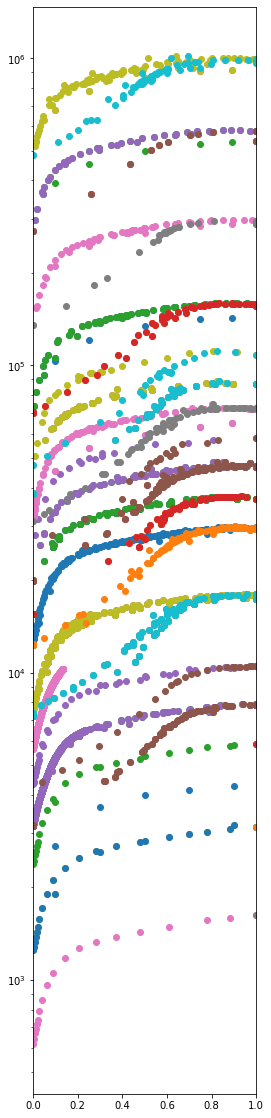

In [318]:
plt.figure(figsize=[4,20])
for T0 in np.linspace(0,700,100):
    slicer=np.logical_and(T0<T,T<T0+10)
    plt.scatter(x[slicer],P[slicer])
    plt.scatter(y[slicer],P[slicer])
plt.yscale('log')
plt.xlim(0,+1)

In [11]:
@njit
def FOBJ(alpha,A,PEXP,x,T):
    ydr=np.zeros((2,))
    PCALC=np.array([Pbol(x=np.array([x[i],1.-x[i]]),T=T[i],y=ydr,alpha=alpha,A=A) for i in range(len(P))  ])
    FOBJ=np.linalg.norm(((PEXP-PCALC)/(PEXP)))
    return FOBJ
FOBJ(alpha,A,P,x,T)

11.997912923710674

In [12]:
from numba import prange
@njit(parallel=False)
def grid(parA,parB,Z,alpha,P,x,T,n):
    for i in prange(n):
        #print(i)
        for j in prange(n):
            A=np.zeros((2,2))
            A[1,0]=parA[i,j]
            A[0,1]=parB[i,j]
            Z[i,j]=FOBJ(alpha,A,P,x,T)

In [16]:
ngrid=2
parA=np.zeros((ngrid,ngrid))
parB=np.zeros((ngrid,ngrid))
Z=np.zeros((ngrid,ngrid))
grid(parA,parB,Z,alpha,P,x,T,ngrid)

In [17]:
alpha[1,0]=alpha[0,1]=0.4
ngrid=100
parA=np.linspace(-20000,20000,ngrid)
parB=np.linspace(-20000,20000,ngrid)
parA,parB=np.meshgrid(parA,parB)
Z=np.zeros_like(parA)

In [18]:
%%timeit -n1 -r1
grid(parA,parB,Z,alpha,P,x,T,ngrid)

1min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


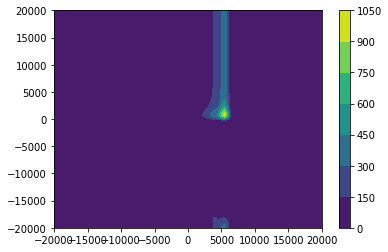

In [20]:
plt.contourf(parA,parB,Z)
plt.colorbar()